In [1]:
# this main code by Ssamot from https://github.com/ssamot/infoGA/blob/master/mnist_snes_example.py
# plot loss function from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# converting MNIST into 3 dimentional from Rabia Yasa Kostas (1700421)/

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from keras_helper import NNWeightHelper
from keras.utils import np_utils
from snes import SNES

Using TensorFlow backend.


In [2]:
# use just a small sample of the train set to test
SAMPLE_SIZE = 500
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 15
# how many times we will loop over ask()/tell()
GENERATIONS = 50

In [3]:
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators = 10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred


def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)

In [4]:

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

In [5]:
# Load MNIST dataset from keras for source domain
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1).astype(np.uint8) * 255
x_train = np.concatenate([x_train, x_train, x_train], 3)

In [6]:
# Load MNIST-M dataset for target domain
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']
x_test=mnistm_test

In [7]:
# create part data for domain classifier, combination from source and target data
x_domain=np.concatenate((x_train,x_test), axis =0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis=0)

In [8]:
#data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
# neural network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(80, activation='relu'))

# this is irrelevant for what we want to achieve
model.compile(loss="mse", optimizer="adam")
print("compilation is over")
nnw = NNWeightHelper(model)
weights = nnw.get_weights()



compilation is over


In [10]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)

test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)
# print('Test MSE:', test_mse)

snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []

    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the label classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        # train the domain classifier and get back the predictions on the training data
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])

        # calculate the label predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        # calculate the domain predictions on a different set
        y_pred2 = predict_classifier(model, clf2, x_domain[subsample_indices_valid])
        score2 = accuracy_score(y_domain[subsample_indices_valid], y_pred2)
        
        # weighted score to give back to snes
        total = (score+(3*-score2))
        told.append(total)

    temp = snes.tell(asked, told)
    log.append(temp)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
    
nnw.set_weights(snes.center)

# predict on target data
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy on target:', test_accuracy)

Total number of weights to evolve is: (756752,)
Non-trained NN Test accuracy: 0.1731
Step 1.0 : -2.590818363273453 best: -2.590818363273453 15
It took 25.036049601971172 seconds to complete generation 1
Step 2.0 : -2.5548902195608783 best: -2.5548902195608783 15
It took 23.37602155096829 seconds to complete generation 2
Step 3.0 : -2.5848303393213574 best: -2.5548902195608783 15
It took 24.437216817983426 seconds to complete generation 3
Step 4.0 : -2.5768463073852295 best: -2.5548902195608783 15
It took 36.09608659497462 seconds to complete generation 4
Step 5.0 : -2.5409181636726546 best: -2.5409181636726546 15
It took 32.308545045903884 seconds to complete generation 5
Step 6.0 : -2.5508982035928143 best: -2.5409181636726546 15
It took 32.64923382306006 seconds to complete generation 6
Step 7.0 : -2.536926147704591 best: -2.536926147704591 15
It took 31.416449278010987 seconds to complete generation 7
Step 8.0 : -2.5708582834331337 best: -2.536926147704591 15
It took 33.344139175023

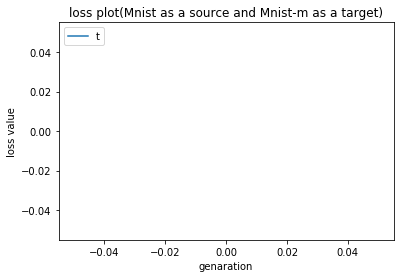

In [11]:

#Plot the loss for each generation
plt.plot(log)
plt.title('loss plot(Mnist as a source and Mnist-m as a target)')
plt.xlabel('genaration')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.savefig('Plot_mnist_mnistm.png')
plt.show()